# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

План работы:
* проверка данных, обработка
* построение модели, изучение показателей и получение предсказаний
* подготовка данных для расчета прибыли
* расчет прибыли и рисков
* Вывод

## Загрузка и подготовка данных

Загружаем библиотеки

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from scipy import stats as st 

Загружаем данные:

In [4]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
pd.options.display.float_format = '{:,.3f}'.format

Построим функцию для вывода основных сведений о данных:
* вывод на экран
* вывод основной информации о файле
* проверка на наличие пропусков
* проверка на наличие повторов
* вывод сведений о распределении данных
* вывод сведений о корреляции (наличие мультиколлениарности)

In [6]:
def plays(dev):
    display(dev.head(5))
    print('Датафрейм содержит', dev.shape[0], 'наблюдений и', dev.shape[1], 'признаков')
    print()
    dev.info()
    print()
    print('Наличие пропусков:', dev.isna().sum().sum())
    print('Наличие повторов:', dev.duplicated().sum())
    print()
    print(f'Сведения о распределении данных')
    print(dev.describe())
    print()
    print(f'Корреляция данных')
    print(dev.corr())
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(geo_0.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'Purples', fmt='.1g');
    print()
        
    #sns.pairplot(dev, hue='product', palette='Purples'); (можно посмотреть, но долго)
    

### Регион geo_0

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


Датафрейм содержит 100000 наблюдений и 5 признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Наличие пропусков: 0
Наличие повторов: 0

Сведения о распределении данных
               f0          f1          f2     product
count 100,000.000 100,000.000 100,000.000 100,000.000
mean        0.500       0.250       2.503      92.500
std         0.872       0.504       3.248      44.289
min        -1.409      -0.848     -12.088       0.000
25%        -0.073      -0.201       0.288      56.498
50%         0.502       0.250       2.516      91.850
75%         1.074       0.701       4.715     128.564
max    

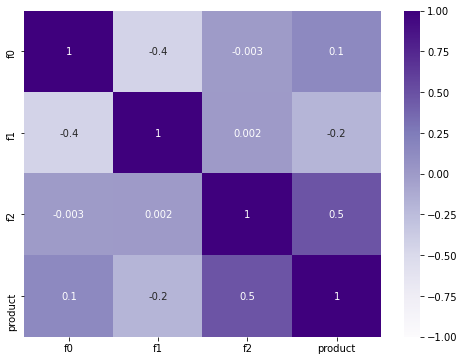

In [7]:
plays(geo_0)

* Датафрейм содержит 100000 наблюдений и 5 признаков
* В файле содержаться признаки f0 f1 f2 и целевой признак, а так же сведения об id скважины. Нам не известны что означают f0 f1 f2, но id не является не является признаком, необходимым для предсказания (удалим его в дальнейшей работе)
* все данные распределены нормально, средние значения соответствуют медиане, стандартное отклонение небольшое
* корреляция признаков слабая, мультиколлениарность отсутствует. 

### Регион geo_1

,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


Датафрейм содержит 100000 наблюдений и 5 признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Наличие пропусков: 0
Наличие повторов: 0

Сведения о распределении данных
               f0          f1          f2     product
count 100,000.000 100,000.000 100,000.000 100,000.000
mean        1.141      -4.797       2.495      68.825
std         8.966       5.120       1.704      45.944
min       -31.610     -26.359      -0.018       0.000
25%        -6.299      -8.268       1.000      26.953
50%         1.153      -4.813       2.011      57.086
75%         8.621      -1.333       4.000     107.813
max    

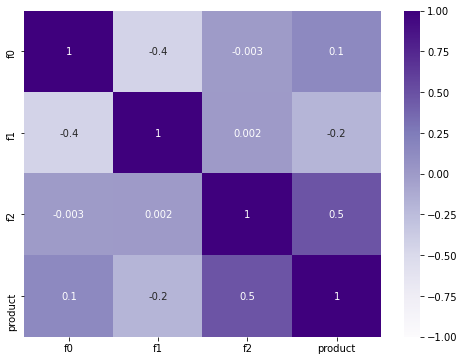

In [8]:
plays(geo_1)

* Датафрейм содержит 100000 наблюдений и 5 признаков
* В файле содержаться признаки f0 f1 f2 и целевой признак, а так же сведения об id скважины. Нам не известны что означают f0 f1 f2, но id не является не является признаком, необходимым для предсказания (удалим его в дальнейшей работе)
* все данные распределены нормально, средние значения соответствуют медиане, стандартное отклонение небольшое
* корреляция признаков незначительная, мультиколлениарность отсутствует. 

### Регион geo_2

,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


Датафрейм содержит 100000 наблюдений и 5 признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Наличие пропусков: 0
Наличие повторов: 0

Сведения о распределении данных
               f0          f1          f2     product
count 100,000.000 100,000.000 100,000.000 100,000.000
mean        0.002      -0.002       2.495      95.000
std         1.732       1.730       3.473      44.750
min        -8.760      -7.084     -11.970       0.000
25%        -1.162      -1.175       0.130      59.450
50%         0.009      -0.009       2.484      94.926
75%         1.159       1.164       4.859     130.595
max    

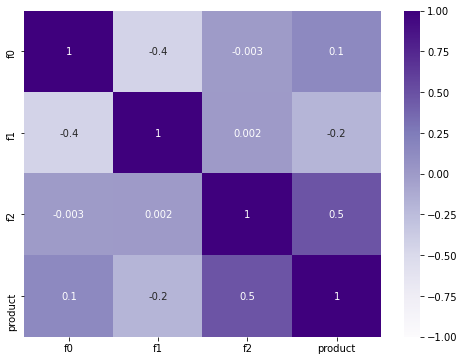

In [9]:
plays(geo_2)

* Датафрейм содержит 100000 наблюдений и 5 признаков
* В файле содержаться признаки f0 f1 f2 и целевой признак, а так же сведения об id скважины. Нам не известны что означают f0 f1 f2, но id не является не является признаком, необходимым для предсказания (удалим его в дальнейшей работе)
* все данные распределены нормально, средние значения соответствуют медиане, стандартное отклонение небольшое
* корреляция признаков незначительная, мультиколлениарность отсутствует. 

**Вывод: Данные готовы к построению модели**

## Обучение и проверка модели

Построим функцию для построения модели, расчета основных показателей и получении предсказаний:
* удаляем колонку id
* разделяем данные на features (признаки) и (target) целевой признак
* разделяем на обучающую и валидационную выборки в соотношении 75/25
* проведем масштабирование признаков
* инициируем модель линейной регрессии и обучим на обучающей выборке
* получим предсказания на валидационной выборке
* расчитаем показатели RMSE, mean_predict, mean_product, R2, MAE

In [10]:
def modeling(geo_region):
    geo_region = geo_region.drop('id', axis=1)
    # удаляем столбец `id`
    features = geo_region.drop('product', axis=1)
    target = geo_region['product']
    
    # разделим выборку на обучающую и валидационную
    features_train, features_valid = train_test_split(features, test_size=0.25, random_state=12345)
    target_train, target_valid = train_test_split(target, test_size=0.25, random_state=12345)
    
    # проведем масштабирование признаков
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_scaler = scaler.transform(features_train)
    features_valid_scaler = scaler.transform(features_valid)
    
    # выведем данные (для проверки)
    print(f'Размеры обучающей выборки {features_train_scaler.shape} и целевого признака {target_train.shape}')
    print(f'Размер валидационной выборки {features_valid_scaler.shape} и целевого признака {target_valid.shape}')
    print()
    # обучаем модель LinearRegression
    model = LinearRegression() 
    model.fit(features_train_scaler, target_train) 
    
    # предсказываем значения
    predictions_valid = model.predict(features_valid_scaler) 
    
    # расчитываем показатели
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5 
    r_2 = r2_score(target_valid, predictions_valid)
    mae = mean_absolute_error(target_valid, predictions_valid)
    mean_predict = predictions_valid.mean()
    mean_product = geo_region['product'].mean()
        
    return rmse, mean_predict, predictions_valid, features_valid_scaler, mean_product, r_2, mae, target_valid

### Регион "geo_0"

Применим функцию `modeling` на данных Региона_0

In [11]:
rmse, mean_predict, predictions_valid, features_valid_scaler, mean_product, r_2, mae, target_valid = modeling(geo_0)
print(f'Корень из средней квадратичной ошибки (RMSE): {rmse:.2f}')
print(f'Коэффициент детерминации (R2): {r_2:.2f}')
print(f'Среднее абсолютное отклонение: {mae:.2f}')
print(f'Среднее предсказанного количество сырья: {mean_predict:.2f} тыс.баррелей')
print(f'Среднее фактическое количество сырья: {mean_product:.2f} тыс.баррелей')

Размеры обучающей выборки (75000, 3) и целевого признака (75000,)
Размер валидационной выборки (25000, 3) и целевого признака (25000,)

Корень из средней квадратичной ошибки (RMSE): 37.58
Коэффициент детерминации (R2): 0.28
Среднее абсолютное отклонение: 30.92
Среднее предсказанного количество сырья: 92.59 тыс.баррелей
Среднее фактическое количество сырья: 92.50 тыс.баррелей


Сохраним предсказания и целевой признак валидационной модели:

In [12]:
Predictions_Geo_0 = predictions_valid
Features_Geo_0 = features_valid_scaler
Target_Geo_0 = target_valid

### Регион "geo_1"

In [13]:
rmse, mean_predict, predictions_valid, features_valid_scaler, mean_product, r_2, mae, target_valid = modeling(geo_1)
print(f'Корень из средней квадратичной ошибки (RMSE): {rmse:.2f}')
print(f'Коэффициент детерминации (R2): {r_2:.4f}')
print(f'Среднее абсолютное отклонение: {mae:.2f}')
print(f'Среднее предсказанного количество сырья: {mean_predict:.2f} тыс.баррелей')
print(f'Среднее фактическое количество сырья: {mean_product:.2f} тыс.баррелей')

Размеры обучающей выборки (75000, 3) и целевого признака (75000,)
Размер валидационной выборки (25000, 3) и целевого признака (25000,)

Корень из средней квадратичной ошибки (RMSE): 0.89
Коэффициент детерминации (R2): 0.9996
Среднее абсолютное отклонение: 0.72
Среднее предсказанного количество сырья: 68.73 тыс.баррелей
Среднее фактическое количество сырья: 68.83 тыс.баррелей


Сохраним предсказания и целевой признак валидационной модели:

In [14]:
Predictions_Geo_1 = predictions_valid
Features_Geo_1 = features_valid_scaler
Target_Geo_1 = target_valid

### Регион "geo_2"

In [15]:
rmse, mean_predict, predictions_valid, features_valid_scaler, mean_product, r_2, mae, target_valid = modeling(geo_2)
print(f'Корень из средней квадратичной ошибки (RMSE): {rmse:.2f}')
print(f'Коэффициент детерминации (R2): {r_2:.2f}')
print(f'Среднее абсолютное отклонение: {mae:.2f}')
print(f'Среднее предсказанного количество сырья: {mean_predict:.2f} тыс.баррелей')
print(f'Среднее фактическое количество сырья: {mean_product:.2f} тыс.баррелей')

Размеры обучающей выборки (75000, 3) и целевого признака (75000,)
Размер валидационной выборки (25000, 3) и целевого признака (25000,)

Корень из средней квадратичной ошибки (RMSE): 40.03
Коэффициент детерминации (R2): 0.21
Среднее абсолютное отклонение: 32.79
Среднее предсказанного количество сырья: 94.97 тыс.баррелей
Среднее фактическое количество сырья: 95.00 тыс.баррелей


Сохраним предсказания и целевой признак валидационной модели:

In [16]:
Predictions_Geo_2 = predictions_valid
Features_Geo_2 = features_valid_scaler
Target_Geo_2 = target_valid

Сведем все данные в один датафрейм для наглядности:

In [17]:
region = [geo_0, geo_1, geo_2]
region_numer = []
rmse_region = []
r_2_region = []
mean_predict_region = []
mean_product_region = []
deviation = []
index = 0
mae_region = []

for value in region:
    rmse, mean_predict, predictions_valid, features_valid_scaler, mean_product, r_2, mae, target_valid = modeling(value)
    region_numer.append(index)
    index +=1
    rmse_region.append(rmse)
    r_2_region.append(r_2)
    mae_region.append(mae)
    mean_predict_region.append(mean_predict)
    mean_product_region.append(mean_product)
    deviation.append(mean_predict/mean_product*100-100)
    
data_region = pd.DataFrame({'Регион': region_numer,
                            'RMSE': rmse_region,
                            'R2': r_2_region,
                            'MAE': mae_region,
                            'Среднее предсказанное': mean_predict_region,
                            'Среднее фактическое': mean_product_region, 'Отклонение %': deviation})
display(data_region)

Размеры обучающей выборки (75000, 3) и целевого признака (75000,)
Размер валидационной выборки (25000, 3) и целевого признака (25000,)

Размеры обучающей выборки (75000, 3) и целевого признака (75000,)
Размер валидационной выборки (25000, 3) и целевого признака (25000,)

Размеры обучающей выборки (75000, 3) и целевого признака (75000,)
Размер валидационной выборки (25000, 3) и целевого признака (25000,)



,Регион,RMSE,R2,MAE,Среднее предсказанное,Среднее фактическое,Отклонение %
0,0,37.579,0.280,30.920,92.593,92.500,0.100
1,1,0.893,1.000,0.719,68.729,68.825,-0.140
2,2,40.030,0.205,32.793,94.965,95.000,-0.037


### Вывод:

Модель для Региона "geo_0"
* Среднее предсказанного сырья незначительно отличается от среднего фактического количества (92,59 / 92,50), что является хорошим результатом
* Корень средней квадратичной ошибки 37,58. Так как он расчитывается в натуральном выражении, то составляет почти 35% от среднего предсказанного количества одной скважины. 
* Коэффициент детерминации (коэфициент количества совподений в прогнозах) должен стремиться к 1, но в нашем случае он равен 0,28. Значит модель будет давать польшое количество ошибок на незнакомых данных.
* Метрика MAE среднее абсолютное отклонение так же как и RMSE чем ближе к нулю тем лучше. Наша модель показала результат 30,92.

Модель для Региона "geo_1"

* Среднее предсказанного сырья незначительно отличается от среднего фактического количества (68,73 / 68,83), что является хорошим результатом
* Корень средней квадратичной ошибки 0.89, очень хороший результат.
* Коэффициент детерминации (коэфициент количества совподений в прогнозах) стремится к 1.
* Метрика MAE среднее абсолютное отклонение 0.72, говорит о хорошем качестве предсказаний.

Модель для Региона "geo_2"
* Среднее количество предсказанного сырья незначительно отличается от среднего фактического количества (94.97 / 95.00), что является хорошим результатом
* Корень средней квадратичной ошибки 40.03, а значит ошибки могут составлять до 50% от среднего предсказанного количества.
* Коэффициент детерминации (коэфициент количества совподений в прогнозах) 0.21, количество ошибок довольно много.
* Метрика MAE среднее абсолютное отклонение 32.79, а должна стремиться к 0.

**Наилучший результат обучаемости модель показала на выборке региона "geo_1".**

## Подготовка к расчёту прибыли

**Вводные данные**
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Количество скважин в разработке - 200.
- Бюджет на одну скважину - 50 млн.руб
- Цена одного барреля - 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- Точка безубыточности скважены - 112 тыс.баррелей


Введем необходимые переменные:

In [18]:
price_barrel = 450 #цена за баррель
budget_thousand = 10000000 # бюджет на бурение (тыс.руб)

Создадим датафпеймы с необходимыми расчетами:
- предсказанное количество баррель
- реально количество баррель
- доход от скважины по предсказанным данным
- доход от скваживы по реальным данным

In [19]:
# создаем датафрейм
data_geo_0 = pd.DataFrame({'predict': Predictions_Geo_0, 'product': Target_Geo_0})
# добавляем расчет выручки по реальным данным о количестве (тыс.руб)
data_geo_0['yield_thousand'] = data_geo_0['product'] * price_barrel
# добавляем расчет предполагаемой выручки по предсказанным данным данным о количестве (тыс.руб)
data_geo_0['yield_thousand_predict'] = data_geo_0['predict'] * price_barrel

# аналогично для остальных регионов
data_geo_1 = pd.DataFrame({'predict': Predictions_Geo_1, 'product': Target_Geo_1})
data_geo_1['yield_thousand'] = data_geo_1['product'] * price_barrel
data_geo_1['yield_thousand_predict'] = data_geo_1['predict'] * price_barrel

data_geo_2 = pd.DataFrame({'predict': Predictions_Geo_2, 'product': Target_Geo_2})
data_geo_2['yield_thousand'] = data_geo_2['product'] * price_barrel
data_geo_2['yield_thousand_predict'] = data_geo_2['predict'] * price_barrel

# проверка
display(data_geo_0.head(), data_geo_0.shape)
display(data_geo_1.head(), data_geo_1.shape)
display(data_geo_2.head(), data_geo_2.shape)

,predict,product,yield_thousand,yield_thousand_predict
71751,95.895,10.039,"4,517.390","43,152.728"
80493,77.573,114.551,"51,548.170","34,907.662"
2655,77.893,132.604,"59,671.636","35,051.688"
53233,90.175,169.072,"76,082.456","40,578.810"
91141,70.510,122.325,"55,046.331","31,729.540"


(25000, 4)

,predict,product,yield_thousand,yield_thousand_predict
71751,82.663,80.860,"36,386.902","37,198.491"
80493,54.432,53.907,"24,257.935","24,494.304"
2655,29.749,30.132,"13,559.564","13,386.942"
53233,53.552,53.907,"24,257.935","24,098.460"
91141,1.244,0.000,0.000,559.735


(25000, 4)

,predict,product,yield_thousand,yield_thousand_predict
71751,93.600,61.212,"27,545.569","42,119.835"
80493,75.105,41.850,"18,832.553","33,797.321"
2655,90.067,57.777,"25,999.462","40,530.064"
53233,105.162,100.054,"45,024.192","47,323.069"
91141,115.303,109.897,"49,453.705","51,886.490"


(25000, 4)

**Точка безубыточности скажины:**

Для расчета количества сырья в скважине, необходимого для безубыточной разработке необходимо:
* найти бюджет на одну скважину (по техническому заданию - 200)
* найти частное бюджета одной скважины и цены за один баррель

In [24]:
print('Точка безубыточности скажины: {:.2f}'.format(budget_thousand / 200 /price_barrel))

Точка безубыточности скажины: 111.11


In [29]:
print('Среднее количество сырья в скважине региона geo_0: {:.2f}'.format(data_geo_0['product'].mean()))
print('Среднее количество сырья в скважине региона geo_1: {:.2f}'.format(data_geo_1['product'].mean()))
print('Среднее количество сырья в скважине региона geo_2: {:.2f}'.format(data_geo_2['product'].mean()))

Среднее количество сырья в скважине региона geo_0: 92.08
Среднее количество сырья в скважине региона geo_1: 68.72
Среднее количество сырья в скважине региона geo_2: 94.88


In [31]:
print('Медиана количества сырья в скважине региона geo_0: {:.2f}'.format(data_geo_0['product'].median()))
print('Медиана количества сырья в скважине региона geo_1: {:.2f}'.format(data_geo_1['product'].median()))
print('Медиана количества сырья в скважине региона geo_2: {:.2f}'.format(data_geo_2['product'].median()))

Медиана количества сырья в скважине региона geo_0: 90.90
Медиана количества сырья в скважине региона geo_1: 57.09
Медиана количества сырья в скважине региона geo_2: 94.98


На основании проведенных расчетов установлено, что необходимое количество баррелей для прохождения точки безубыточности нет ни в одном регионе.

**Данные готовы к работе**

## Расчёт прибыли и рисков 

Проанализируем возможную прибыль и риски техникой Bootstrap:

Пишем функцию о расчете выручки для 200 лучших из рандомно взятых 500 скважин.

In [78]:
def calculations(geo, budget_thousand):
    state = np.random.RandomState(12345)
    values = [] # переменная выручки
    for i in range(1000): 
        data = geo.sample(n=500, random_state=state, replace=True) # создаем 500 выборок
        predict = data.sort_values(by='predict', ascending=False)[:200] # выбираем ТОП-200 скважин по предсказанным данным 
        rev = (predict['yield_thousand'].sum() - budget_thousand) # общая выручка по реальным данным
        values.append(rev / 1000) # создаем список возможной выручки
    values = pd.Series(values)
    lower = values.quantile(0.025) # 2,5%-квантиль (доверительный интерсвал 95%)
    hight = values.quantile(0.975) # 97,5%-квантиль
    loss = values[values < 0] # сортируем убыточные скважины
    mean = values.mean() # средняя возможная прибыль 
    print(f'Средняя прибыль: {mean:.2f} млн.руб.')
    print(f'2,5%-квантиль: {lower:.2f} млн.руб.')
    print(f'97,5%-квантиль: {hight:.2f} млн.руб.')
    print('Количество убыточных экспериментов:', loss.count())
    print('Вероятность убытков: {:.2%}'.format(loss.count()/len(values)))
    print('Максимальный убыток: {:.2f}'.format(loss.min()))
    print('Максимальная прибыль: {:.2f}'.format(values.max()))
    print('Количество экспериментов:', len(values))

In [79]:
geo = [data_geo_0, data_geo_1, data_geo_2]
x = 0
for value in geo:
    print(f' Данные по региону № {x}')
    calculations(value, budget_thousand)
    x += 1
    print()

 Данные по региону № 0
Средняя прибыль: 396.16 млн.руб.
2,5%-квантиль: -111.22 млн.руб.
97,5%-квантиль: 909.77 млн.руб.
Количество убыточных экспериментов: 69
Вероятность убытков: 6.90%
Максимальный убыток: -369.57
Максимальная прибыль: 1349.27
Количество экспериментов: 1000

 Данные по региону № 1
Средняя прибыль: 456.05 млн.руб.
2,5%-квантиль: 33.82 млн.руб.
97,5%-квантиль: 852.29 млн.руб.
Количество убыточных экспериментов: 15
Вероятность убытков: 1.50%
Максимальный убыток: -192.27
Максимальная прибыль: 1154.05
Количество экспериментов: 1000

 Данные по региону № 2
Средняя прибыль: 404.40 млн.руб.
2,5%-квантиль: -163.35 млн.руб.
97,5%-квантиль: 950.36 млн.руб.
Количество убыточных экспериментов: 76
Вероятность убытков: 7.60%
Максимальный убыток: -417.86
Максимальная прибыль: 1330.59
Количество экспериментов: 1000



**Вывод:**

При расчете прибыли и убытко на выборке региона *data_geo_2* установлено:
- вероятность убытков на 95% доверительном интервале составляет 7,6%
- Из 1000 проведенных экспериментов 76 оказались неудачными
- Данный регион показывает самый большой уровень убытков (417 млн), который равен средней возможной прибыли (404 млн)
- Медиана количества сырья в одной скважине региона 94.98 баррелей. Это наибольшее количество из всех регионов

*Разработка скважи в данном регионе является крайне рискованным мероприятием, однако и возможно, максимально прибыльным.*

При расчете прибыли и убытко на выборке региона *data_geo_0* установлено:
- вероятность убытков на 95% доверительном интервале составляет 6,9%
- Из 1000 проведенных экспериментов 69 оказались неудачными
- Однако данный регион показывает самую большую возможную прибыль (1349 млн.) при самой маленькой средней (396,16 млн.). 

При расчете прибыли и убытко на выборке региона *data_geo_2* установлено:
- вероятность убытков на 95% доверительном интервале составляет 1,50%, **что соответствует техническому заданию**
- Из 1000 проведенных экспериментов 15 оказались неудачными
- Границы доверительного интервала начинаются с уровня 33,8 млн, в то время как в других регионах они имеют отрицательные значения
- Данный регион показывает самый большой уровень средней прибыли (456 млн) и самый маленький уровень максимальной прибыли (1154 млн) 
- Медиана количества сырья в одной скважине региона: 57.09 бареллей. Это минимальный показатель из всех регионов.

*Разработка скважин в данном регионе не будет убыточной, но и сверхприбыли не принесет.*


## Вывод:

Вводные данные: Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Задачи:
- Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
- Проанализировать возможную прибыль и риски техникой Bootstrap.

1. Подготовка данных:
* Датафреймы содержат по 100000 наблюдений и 5 признаков
* В файлах имеются признаки f0 f1 f2 и целевой признак, а так же сведения об id скважины
* все данные распределены нормально, средние значения соответствуют медиане, стандартное отклонение небольшое
* корреляция признаков незначительная, мультиколлениарность отсутствует. 

2. Обучение и проверка модели:

Модель для Региона "geo_0"
* Среднее предсказанного сырья незначительно отличается от среднего фактического количества (92,59 / 92,50), что является хорошим результатом
* Корень средней квадратичной ошибки 37,58. Так как он расчитывается в натуральном выражении, то составляет почти 35% от среднего предсказанного количества одной скважины. 
* Коэффициент детерминации (коэфициент количества совподений в прогнозах) должен стремиться к 1, но в нашем случае он равен 0,28. Значит модель будет давать польшое количество ошибок на незнакомых данных.
* Метрика MAE среднее абсолютное отклонение так же как и RMSE чем ближе к нулю тем лучше. Наша модель показала результат 30,92.

Модель для Региона "geo_1"

* Среднее предсказанного сырья незначительно отличается от среднего фактического количества (68,73 / 68,83), что является хорошим результатом
* Корень средней квадратичной ошибки 0.89, очень хороший результат.
* Коэффициент детерминации (коэфициент количества совподений в прогнозах) стремится к 1.
* Метрика MAE среднее абсолютное отклонение 0.72, говорит о хорошем качестве предсказаний.

Модель для Региона "geo_2"
* Среднее количество предсказанного сырья незначительно отличается от среднего фактического количества (94.97 / 95.00), что является хорошим результатом
* Корень средней квадратичной ошибки 40.03, а значит ошибки могут составлять до 50% от среднего предсказанного количества.
* Коэффициент детерминации (коэфициент количества совподений в прогнозах) 0.21, количество ошибок довольно много.
* Метрика MAE среднее абсолютное отклонение 32.79, а должна стремиться к 0.

3. Расчет прибыли и рисков:

При расчете прибыли и убытко на выборке региона *geo_2* установлено:
- вероятность убытков на 95% доверительном интервале составляет 7,6%
- Из 1000 проведенных экспериментов 76 оказались неудачными
- Данный регион показывает самый большой уровень убытков (417 млн), который равен средней возможной прибыли (404 млн) 

При расчете прибыли и убытко на выборке региона *geo_0* установлено:
- вероятность убытков на 95% доверительном интервале составляет 6,9%
- Из 1000 проведенных экспериментов 69 оказались неудачными
- Однако данный регион показывает самую большую возможную прибыль (1349 млн.) при самой маленькой средней (396,16 млн.). 

При расчете прибыли и убытко на выборке региона *geo_1* установлено:
- вероятность убытков на 95% доверительном интервале составляет 1,50%, **что соответствует техническому заданию**
- Из 1000 проведенных экспериментов 15 оказались неудачными
- Границы доверительного интервала начинаются с уровня 33,8 млн, в то время как в других регионах они имеют отрицательные значения
- Данный регион показывает самый большой уровень средней прибыли (456 млн) и самый маленький уровень максимальной прибыли (1154 млн) 

4. Проведенный анализ Bootstrap даёт нам явно понять, что регион **geo_1**, будет предпочтительнее, так как при разработке 200 скважин, вероятность убытков наименьшая - 1,5%.